# Verify the weight of u+p

## Prepare environment and  define parameters 

In [1]:
is_colab = False
import sys
if is_colab:
    !pip install -q torch==1.8.1
    !pip install -q torchvision==0.4.0
    !pip install -q qiskit==0.14.0
    !pip install qfnn


import torch
import torchvision

import qiskit
from qiskit import  QuantumCircuit, ClassicalRegister
import numpy as np
import functools

sys.path.append('../')
from src.qfnn.qf_fb.q_output import fire_ibmq,analyze,add_measure
from src.qfnn.qf_circ.n_lyr_circ import N_LYR_Circ
from src.qfnn.qf_circ.u_lyr_circ import U_LYR_Circ
from src.qfnn.qf_circ.p_lyr_circ import P_LYR_Circ
from src.qfnn.qf_fb.c_input import load_data,to_quantum_matrix
from src.qfnn.qf_net.utils import binarize

print = functools.partial(print, flush=True)






## Load data

In [2]:

################ Zhirui on 12-30-2020 ################
# Parameters of settings
######################################################
interest_num = [3,6]
img_size = 4
 # how many samples per batch 
batch_size = 32
inference_batch_size = 1


################ Zhirui on 12-30-2020 ################
# path
######################################################
if is_colab:
    data_path = '/content/data' #mnist  path
else: 
    data_path = '/home/hzr/Software/quantum/qc_mnist/pytorch/data'

################ Zhirui on 12-30-2020 ################
# load data.
######################################################

train_loader, test_loader = load_data(interest_num,data_path,False,img_size,batch_size,inference_batch_size,False)
for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix = to_quantum_matrix(data)
    break

Batch Id: 0, Target: tensor([0])


## Inference

In [3]:
################ Weiwen on 12-30-2020 ################
# Parameters of the trained model
# The training procedure will be found in another repo
# https://github.com/weiwenjiang/QuantumFlow
######################################################

# Model initialization
# weight_1 = torch.tensor([[1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,    1.,  1.],[-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1.]])
# weight_2 = torch.tensor([[1.,  -1.],[-1.,  -1.]])
if is_colab:
    resume_path = '/content/libs/best_model/v_u.tar' #model path
else:
    resume_path = '/home/hzr/Software/quantum/JQuantumFlow_tutorial/model/u4_p2/model_best.tar' #model path
checkpoint = torch.load(resume_path, map_location='cpu')
print(checkpoint['state_dict']['fc0.weight'])
print(checkpoint['state_dict']['fc1.weight'])
weight_1 = checkpoint['state_dict']['fc0.weight']
weight_2 = checkpoint['state_dict']['fc1.weight']
norm_flag = [False,False]
norm_para = torch.tensor([0.3060,0.6940])



tensor([[-4.9759e+00,  2.0144e+00,  5.4221e+00,  4.0397e+00,  3.1573e+00,
          5.6547e+00, -2.9148e-02,  5.5174e+00,  5.2676e+00,  6.9286e+00,
          6.2207e+00,  6.5940e+00, -5.1557e+00, -1.1866e+00,  3.3104e-02,
         -5.0546e-01],
        [ 8.7392e-02, -5.5877e-04,  4.4119e-03, -2.9086e-01, -4.5692e-03,
          6.7037e-02,  2.3283e-04, -4.5438e-03, -5.0428e-03,  5.5431e-04,
         -8.4613e-02, -7.8030e-02,  8.1878e-02,  1.0454e-04, -4.6076e-03,
          3.4129e-01],
        [ 1.1917e-01, -5.9777e-03, -2.7039e-04, -1.7104e-03,  6.9172e-02,
         -6.9876e-04, -6.8757e-02,  7.8472e-03,  3.5071e-03,  6.6695e-04,
         -1.1418e-03, -6.9806e-02, -2.4577e-02,  5.7041e-02, -3.6213e-03,
          4.1237e-01],
        [ 6.5811e+00,  6.5627e+00,  5.5525e+00,  3.9594e+00,  4.3861e+00,
          5.2081e+00,  6.9903e+00,  3.6691e+00,  3.7794e+00, -4.1419e+00,
          4.2351e+00, -1.2405e-01,  7.0590e+00,  6.9925e+00,  6.8708e+00,
          5.8040e+00]])
tensor([[-6.6118, -

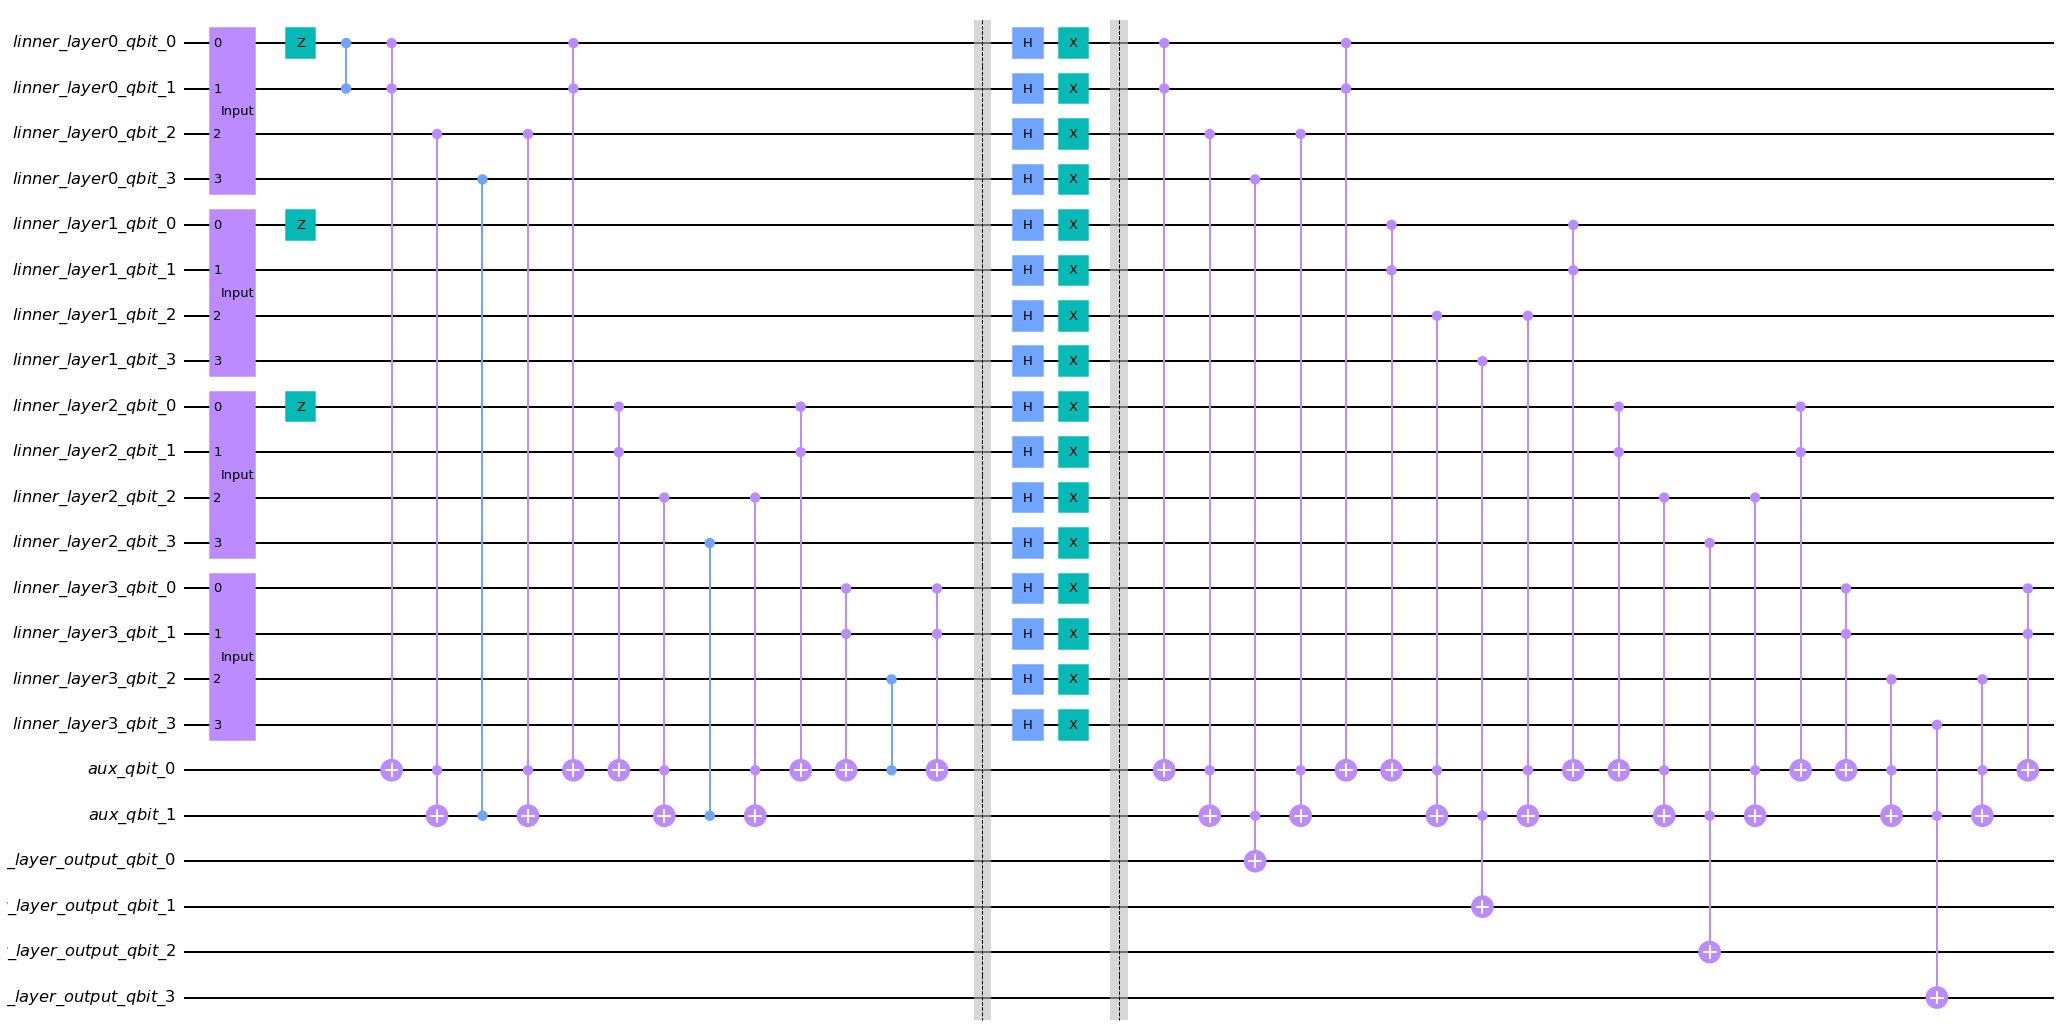

In [4]:
################ Weiwen on 12-30-2020 ################
# Generate the circuit of u-layer
######################################################
#define your input and output number
u_layer = U_LYR_Circ(4,4) 
#init circuit
circuit = QuantumCircuit()
#add input qubit to your circuit
inps = u_layer.add_input_qubits(circuit)

#add auxiliary qubit to your circuit
aux =u_layer.add_aux(circuit)

#add output qubit to your circuit
u_layer_out_qubits = u_layer.add_out_qubits(circuit)

#add ulayer to your circuit
# print(quantum_matrix)
u_layer.forward(circuit,binarize(weight_1) ,inps,u_layer_out_qubits,quantum_matrix,aux)

#show your circuit
if is_colab:
    layout = 'text'
    fold = 300
else:
    layout = 'mpl'
    fold = 300

circuit.draw(layout,fold=fold)



Output layer created!


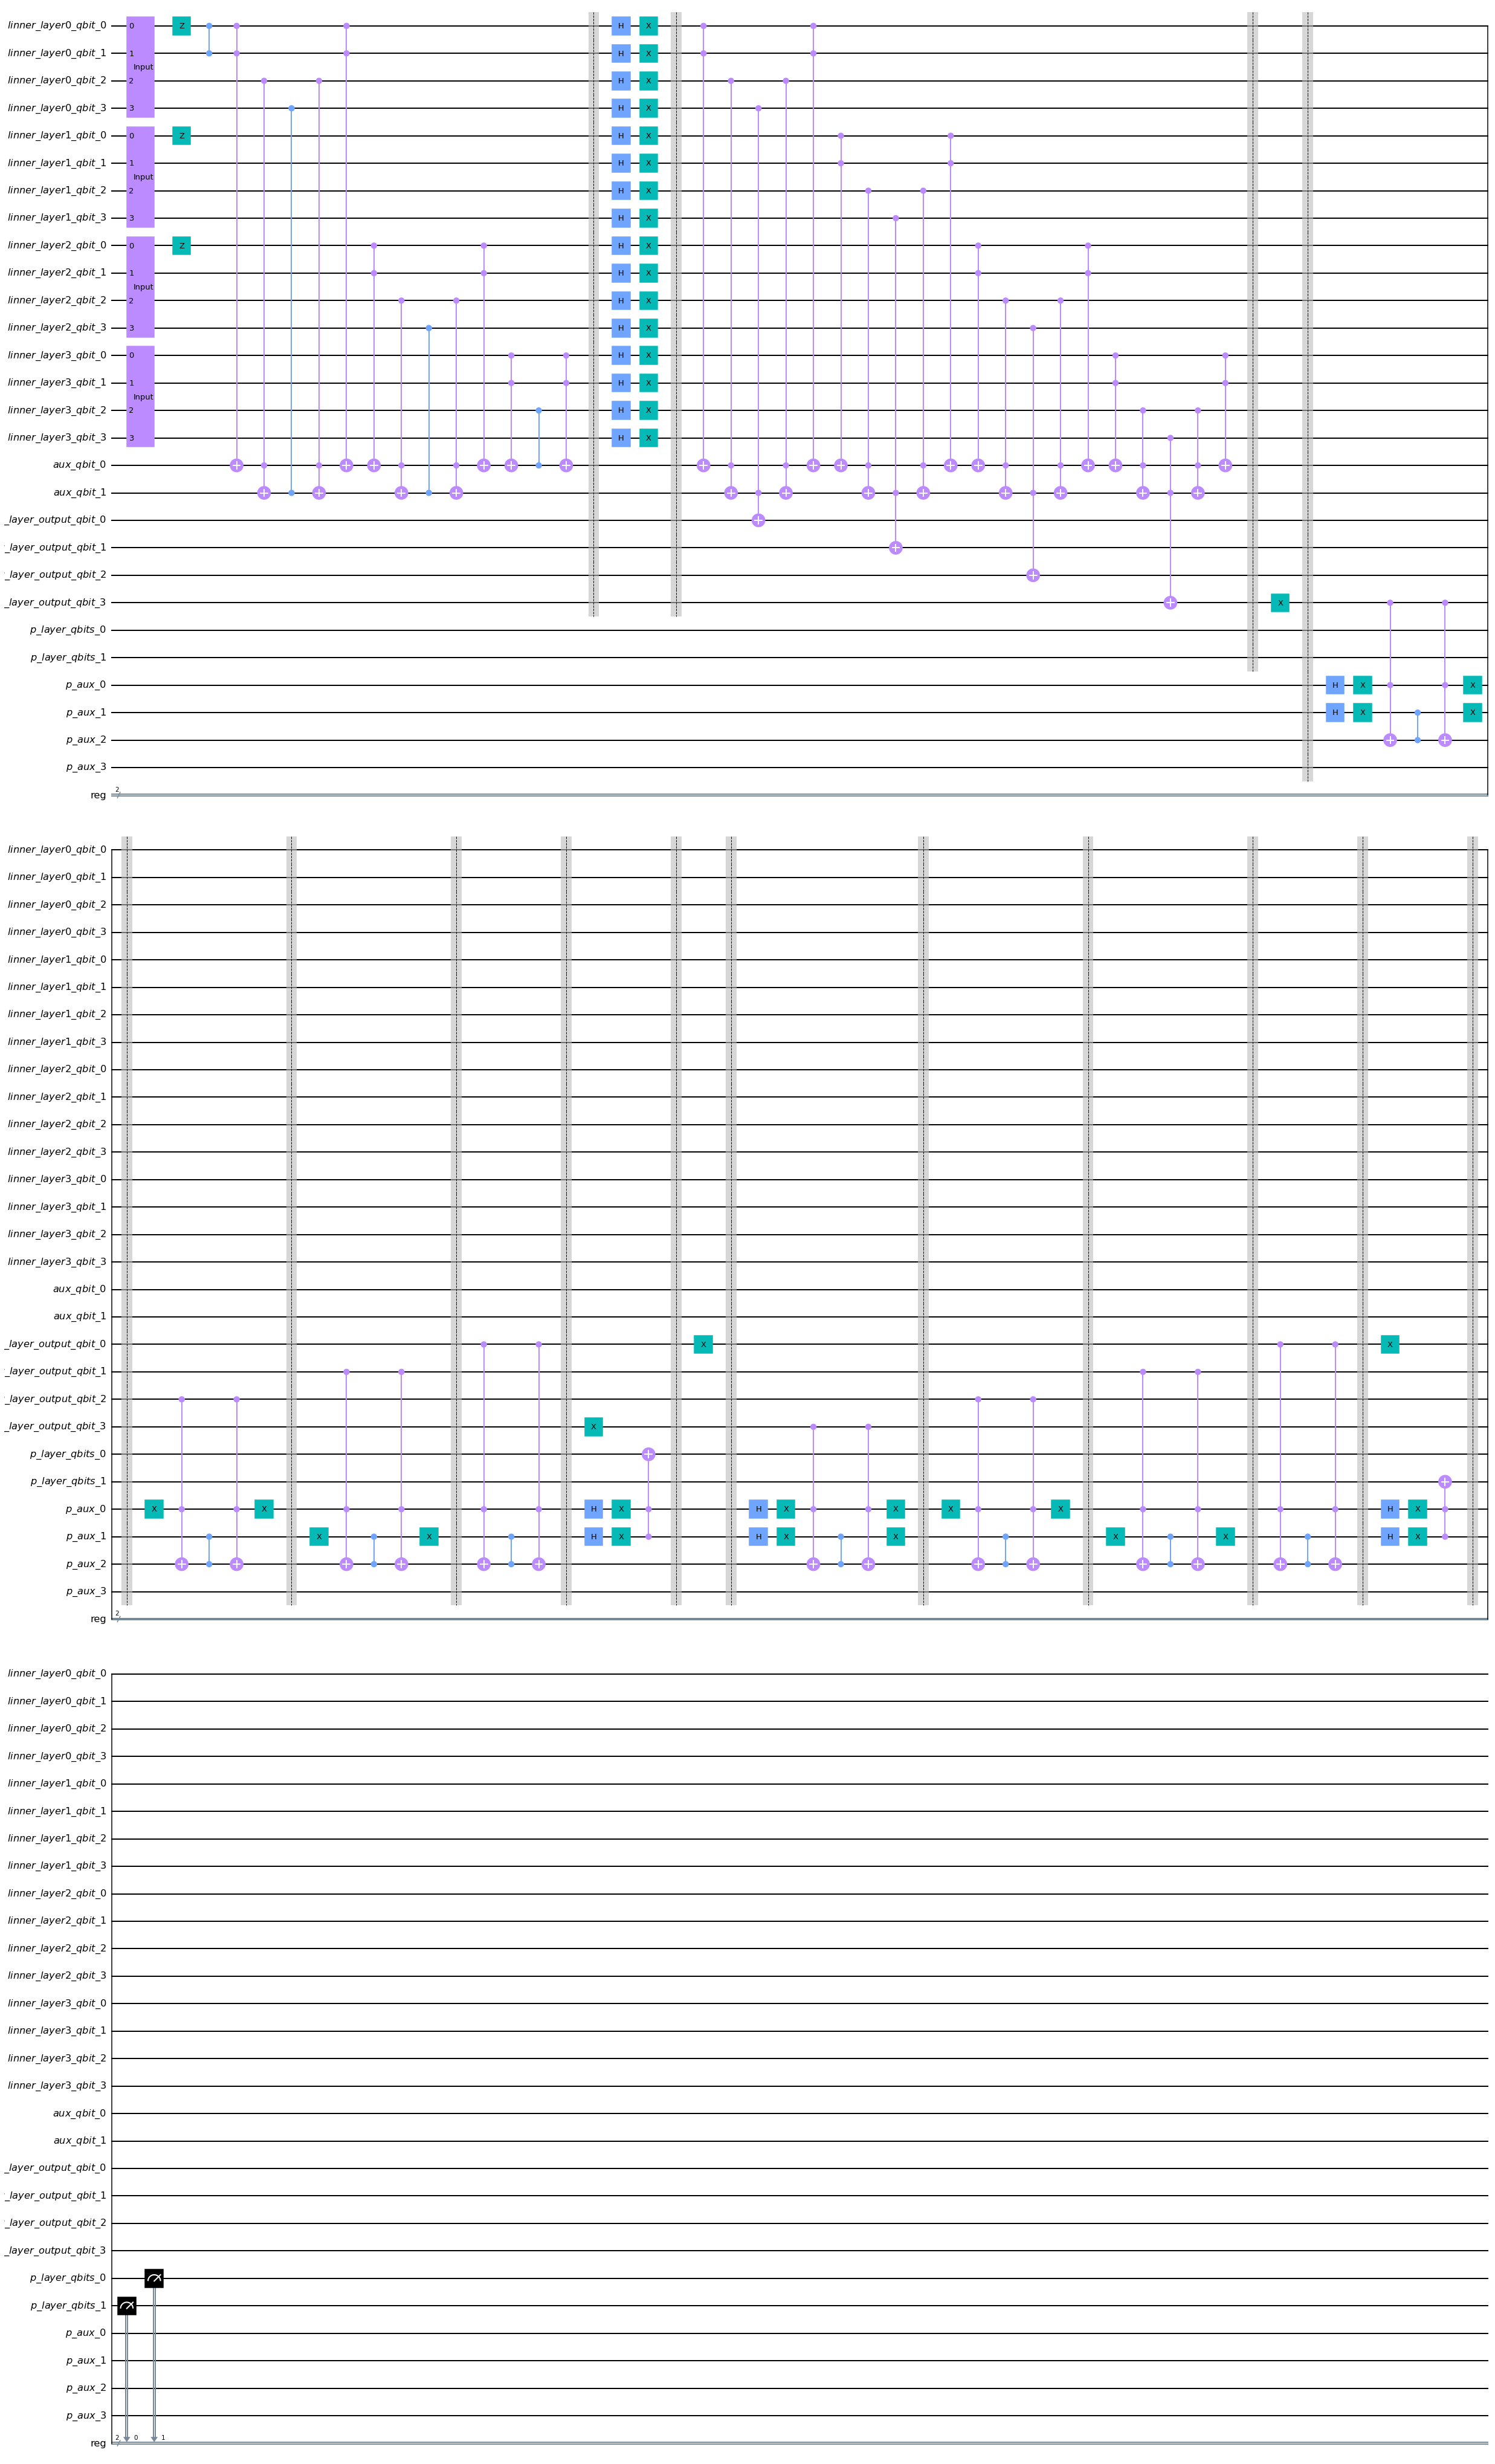

In [5]:
################ Weiwen on 12-30-2020 ################
# Quantum circuit implementation of the output layer
# fundamentals, please see our Nature Communication
# paper (P-LYR) https://arxiv.org/pdf/2006.14815.pdf
######################################################


p_layer = P_LYR_Circ(4,2)
p_layer_output = p_layer.add_out_qubits(circuit)
circuit.barrier()
p_aux = p_layer.add_aux(circuit,"p_aux")
p_layer.forward(circuit,binarize(weight_2),u_layer_out_qubits,p_layer_output,p_aux)


# norm = N_LYR_Circ(2)
# norm_qubit = norm.add_norm_qubits(circuit)
# norm_output_qubit = norm.add_out_qubits(circuit)
# norm.forward(circuit,p_layer_output,norm_qubit,norm_output_qubit,norm_flag,norm_para)


add_measure(circuit,p_layer_output,'reg')

print("Output layer created!")

circuit.draw('mpl',fold =50)

### Non-Optimized Circuit v.s. Optimized Circuit

Let's test and compare!


In [6]:
################ Weiwen on 12-30-2020 ################
# Quantum simulation
######################################################

# Optimized one
qc_shots=8192
opt_counts = fire_ibmq(circuit,qc_shots,True)
print("="*10,"Optimized Circuit","="*10)
(opt_mycount,bits) = analyze(opt_counts)
opt_class_prob=[]
for b in range(bits):
    opt_class_prob.append(float(opt_mycount[b])/qc_shots)


print("="*10,"Optimized Circuit","="*10)
print("Optimized Circuit Depth:",circuit.depth())
print("Result of optimized QC:",opt_class_prob)
print("Prediction class: {}".format(opt_class_prob.index(max(opt_class_prob))))
print("Target class: {}".format(target[0]))
if opt_class_prob.index(max(opt_class_prob))==target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")
print("="*30)

========== Optimized Circuit ==========
========== Optimized Circuit ==========
Optimized Circuit Depth: 81
Result of optimized QC: [0.7281494140625, 0.3800048828125]
Prediction class: 0
Target class: 0
Correct prediction


In [7]:
from src.qfnn.qf_fb.c_qf_mixer import Net
from src.qfnn.qf_fb.c_input import ToQuantumData
neural_in_layers = 'u:4,p:2'
layers = []
for item1 in neural_in_layers.split(","):
    x= item1.split(":")
    layer =[]
    layer.append(x[0].strip())
    layer.append(int(x[1].strip()))
    layers.append(layer)

print("layers:",layers)
model = Net(img_size,layers,False,False)
model.load_state_dict(checkpoint["state_dict"])
# print(quantum_matrix)
to_quantum_data = ToQuantumData(img_size)
output_data = to_quantum_data(data)
output = model.forward(output_data,False)
print(output)

layers: [['u', 4], ['p', 2]]
tensor([[0.3764, 0.2041]], grad_fn=<DivBackward0>)
